In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from scipy.cluster.hierarchy import dendrogram
from src.graphs import SPGraph
from src.mining import compute_communities, compute_linkage

In [2]:
font = {'size' : 15}
matplotlib.rc('font', **font)

### Create graph

In [3]:
N = 640
rho = 1
k = 16
comm_sizes = [160, 40, 10]

graph = SPGraph(N, rho, k, comm_sizes)

### Compute graph dendrogram

In [5]:
scales, scale2linkage = compute_linkage(
    graph=graph,
    scales_num=50,
    r_num=60)

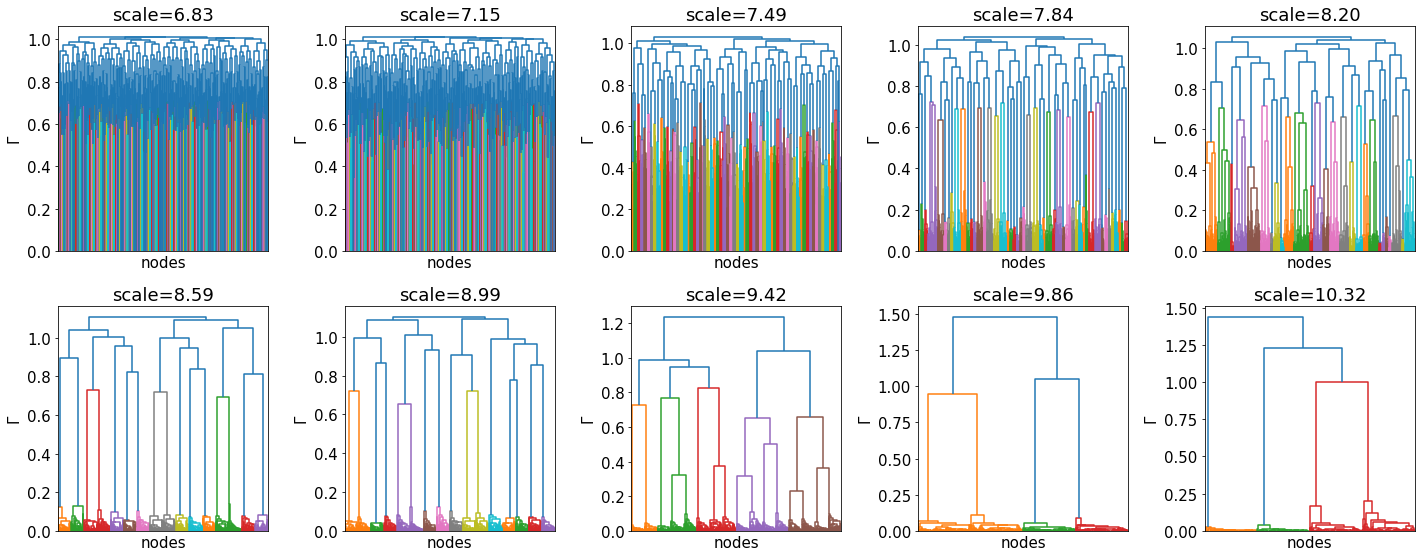

In [15]:
nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8))

for s, linkage in enumerate(scale2linkage[::5]):
    i = s // ncols
    j = s % ncols
    ax = axes[i][j]
    _ = dendrogram(linkage, no_labels=True, ax=ax)
    ax.set_title('scale={:.2f}'.format(scales[s]))
    ax.set_xlabel('nodes')
    ax.set_ylabel(r'$\Gamma$')

plt.tight_layout()
plt.savefig('plots/sp_graph_dendrograms.pdf', format='pdf', transparent=True)
plt.show()

### Compute multiscale communities

In [7]:
communities = compute_communities(scale2linkage)

### Compute Adjusted Rand Index

In [10]:
from math import comb

def adjusted_rand_index(p1, p2):
    n = len(p1)
    n_scales_1 = max(p1)
    n_scales_2 = max(p2)
    matrix = np.zeros((n_scales_1, n_scales_2))
    for i, j in zip(p1, p2):
        matrix[i - 1, j - 1] += 1
    
    col_sum = np.sum(matrix, axis=0)
    row_sum = np.sum(matrix, axis=1)
    
    square_col_sum = np.sum(col_sum ** 2)
    square_row_sum = np.sum(row_sum ** 2)
    
    t1 = comb(n, 2)
    t2 = np.sum(matrix ** 2)
    t3 = 0.5 * (square_col_sum + square_row_sum)
    
    
    nc = (
        n * (n ** 2 + 1) 
        - (n + 1) * square_row_sum 
        - (n + 1) * square_col_sum 
        + 2 * (square_row_sum * square_col_sum) / n
    ) / (2 * (n - 1))
    
    A = t1 + t2 - t3

    if t1 == nc:
        return 0
    return (A - nc) / (t1 - nc)

100%|██████████| 50/50 [00:00<00:00, 566.13it/s]


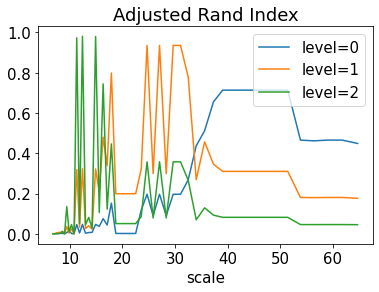

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

plt.figure()
for level in [0, 1, 2]:
    rand_idx = [
        adjusted_rand_index(communities[:, i], graph.communities[:, level])
        for i, scale in tqdm(enumerate(scales), total=len(scales))
    ]
    plt.plot(scales, rand_idx, label=f'level={level}')
    plt.title('Adjusted Rand Index')
    plt.xlabel('scale')
plt.legend()
plt.savefig('plots/sp_adj_rand_index.pdf', format='pdf', transparent=True)
plt.show()